## Project topic

The aim of the project is to predict high school students' ```GradeClass``` based on their demographics, study habits, parental involvement, extracurricular activities, and academic performance. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

## Data preprocessing

### Import data

In [2]:
data = pd.read_csv("/kaggle/input/d/rabieelkharoua/students-performance-dataset/Student_performance_data _.csv")
data.head(10)

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0
5,1006,18,0,0,1,8.191219,0,0,1,1,0,0,0,3.084184,1.0
6,1007,15,0,1,1,15.601680,10,0,3,0,1,0,0,2.748237,2.0
7,1008,15,1,1,4,15.424496,22,1,1,1,0,0,0,1.360143,4.0
8,1009,17,0,0,0,4.562008,1,0,2,0,1,0,1,2.896819,2.0
9,1010,16,1,0,1,18.444466,0,0,3,1,0,0,0,3.573474,0.0


```StudentID``` is unique and it doesn't influence student's ```GradeClass```, so this variable isn't useful. 

In [3]:
data = data.drop(columns = 'StudentID')

### Missing values

In [4]:
data.isnull().sum()

Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

There are no missing values

### Duplication

In [5]:
sum(data.duplicated())

0

There are no duplicated rows

### Basic statistics

In [6]:
data[['StudyTimeWeekly','Absences','GPA']].describe()

,StudyTimeWeekly,Absences,GPA
count,2392.000000,2392.000000,2392.000000
mean,9.771992,14.541388,1.906186
std,5.652774,8.467417,0.915156
min,0.001057,0.000000,0.000000
25%,5.043079,7.000000,1.174803
50%,9.705363,15.000000,1.893393
75%,14.408410,22.000000,2.622216
max,19.978094,29.000000,4.000000


### Feature distribution

In [7]:
sns.set_palette('pastel')

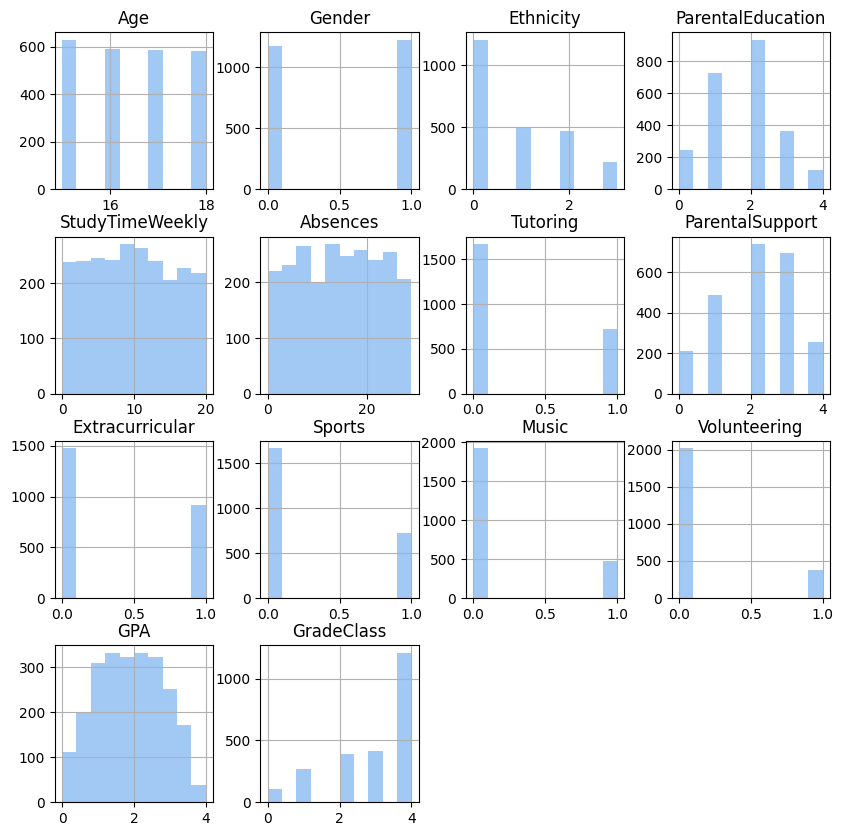

In [8]:
data.hist(figsize = (10,10))
plt.show()

We can see that there are 3 numerical variables: ```StudyTimeWeekly```, ```Absences``` and ```GPA```. The remaining variables are categorical or boolean.

### Correlation

In [9]:
corr_matrix = data.corr()
corr_matrix.style.background_gradient(cmap = 'coolwarm').format(precision = 2)

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
Age,1.00,0.04,-0.03,0.03,-0.01,-0.01,-0.01,0.03,-0.03,-0.05,-0.00,0.01,0.00,-0.01
Gender,0.04,1.00,0.02,0.01,0.01,0.02,-0.03,0.01,-0.01,-0.01,0.01,-0.00,-0.01,0.02
Ethnicity,-0.03,0.02,1.00,0.03,0.01,-0.03,-0.02,0.02,-0.01,-0.00,-0.01,0.01,0.03,-0.02
ParentalEducation,0.03,0.01,0.03,1.00,-0.01,0.04,-0.02,-0.02,0.01,0.00,0.04,0.01,-0.04,0.04
StudyTimeWeekly,-0.01,0.01,0.01,-0.01,1.00,0.01,0.03,0.04,-0.02,0.01,0.01,-0.02,0.18,-0.13
Absences,-0.01,0.02,-0.03,0.04,0.01,1.00,-0.02,0.00,0.00,0.04,-0.01,-0.02,-0.92,0.73
Tutoring,-0.01,-0.03,-0.02,-0.02,0.03,-0.02,1.00,-0.00,0.00,0.01,-0.01,-0.05,0.15,-0.11
ParentalSupport,0.03,0.01,0.02,-0.02,0.04,0.00,-0.00,1.00,-0.01,-0.01,0.04,-0.01,0.19,-0.14
Extracurricular,-0.03,-0.01,-0.01,0.01,-0.02,0.00,0.00,-0.01,1.00,-0.01,-0.01,-0.01,0.09,-0.07
Sports,-0.05,-0.01,-0.00,0.00,0.01,0.04,0.01,-0.01,-0.01,1.00,-0.02,-0.00,0.06,-0.03


### Change data types

```GPA``` shouldn't be used as a feature variable to predict ```GradeClass```, as they both represent the same thing. 


In [10]:
data = data.drop(columns = 'GPA')

In [11]:
data.nunique()

Age                     4
Gender                  2
Ethnicity               4
ParentalEducation       5
StudyTimeWeekly      2392
Absences               30
Tutoring                2
ParentalSupport         5
Extracurricular         2
Sports                  2
Music                   2
Volunteering            2
GradeClass              5
dtype: int64

In [12]:
data['Age'] = data['Age'].astype('category')
data['Ethnicity'] = data['Ethnicity'].astype('category')
data['ParentalEducation'] = data['ParentalEducation'].astype('category')
data['ParentalSupport'] = data['ParentalSupport'].astype('category')
data['GradeClass'] = data['GradeClass'].astype('category')

data['Gender'] = data['Gender'].astype(bool)
data['Tutoring'] = data['Tutoring'].astype(bool)
data['Extracurricular'] = data['Extracurricular'].astype(bool)
data['Sports'] = data['Sports'].astype(bool)
data['Music'] = data['Music'].astype(bool)
data['Volunteering'] = data['Volunteering'].astype(bool)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   category
 1   Gender             2392 non-null   bool    
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   bool    
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   bool    
 9   Sports             2392 non-null   bool    
 10  Music              2392 non-null   bool    
 11  Volunteering       2392 non-null   bool    
 12  GradeClass         2392 non-null   category
dtypes: bool(6), category(5), float64(1), int64(1)
memory usage: 64.2 KB


### Standarization

In [14]:
cols_to_scale = ['StudyTimeWeekly','Absences']
std_scaler = StandardScaler()
data[cols_to_scale] = std_scaler.fit_transform(data[cols_to_scale])

## Visualization

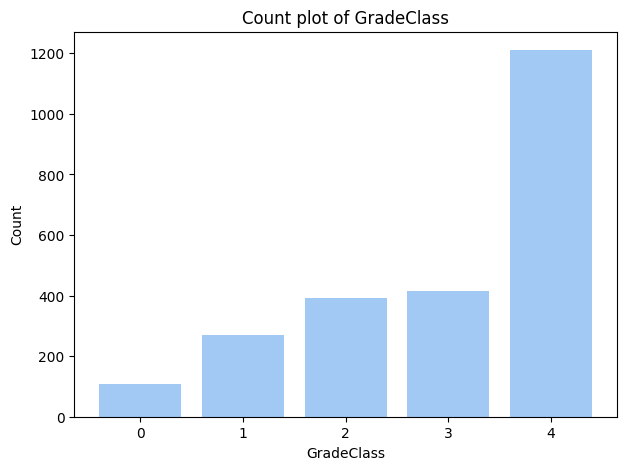

In [15]:
grade_counts = data['GradeClass'].value_counts()

plt.figure(figsize=(7,5))
plt.bar(grade_counts.index, grade_counts)
plt.xlabel('GradeClass')
plt.ylabel('Count')
plt.title('Count plot of GradeClass')
plt.show()

The target variable is imbalanced, which means we should use stratified splitting.

## Building models

### Splitting dataset

In [16]:
kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 44)

In [17]:
X = data.drop('GradeClass', axis = 1)
y = data['GradeClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 44, stratify = y)

### Models

In [18]:
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter = 900),
    'Deicision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-nearest Neighbours': KNeighborsClassifier(),
    'SVM': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier()
}

accuracy = []
model_name = []

In [19]:
for name, clf in classification_models.items():
    score = cross_val_score(clf, X_train, y_train, cv = kfold, scoring = 'accuracy')
    score_mean = score.mean()
    model_name.append(name)
    accuracy.append(score_mean)

In [20]:
results = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy})
print(results)

                  Model  Accuracy
0   Logistic Regression  0.701341
1        Deicision Tree  0.601678
2         Random Forest  0.692447
3  K-nearest Neighbours  0.604469
4                   SVM  0.623979
5  Gaussian Naive Bayes  0.652719
6     Gradient Boosting  0.699068


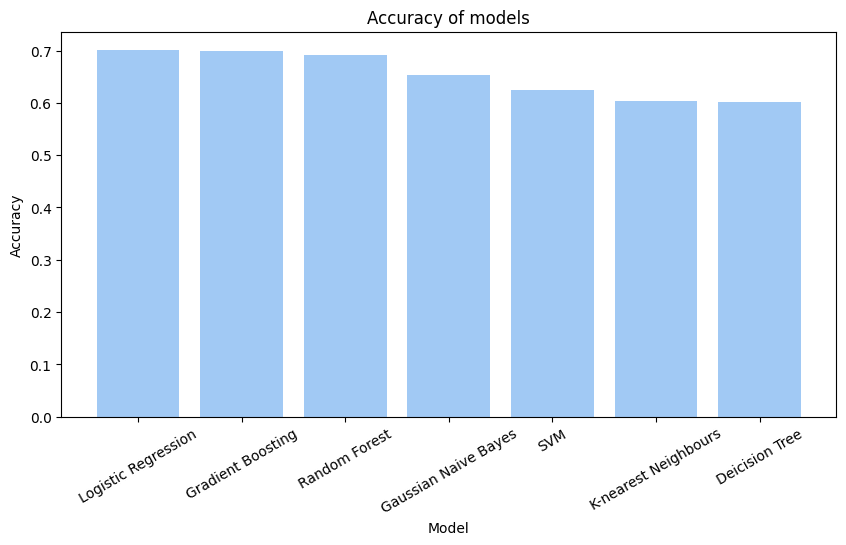

In [21]:
results_sorted = results.sort_values('Accuracy', ascending = False)

plt.figure(figsize=(10,5))
plt.bar(results_sorted['Model'], results_sorted['Accuracy'])
plt.xlabel('Model')
plt.xticks(rotation = 30)
plt.ylabel('Accuracy')
plt.title('Accuracy of models')
plt.show()